# Final Project: Kaká's Impact on AC Milan
Ricardo Kaká's impact on AC Milan's performance using data from the European Soccer Database

#1 : import necessary files
#2 : connect to the SQLite database
#3 : see all the tables in the file so we can figure out which we need

In [3]:
#1
import sqlite3 
import pandas as pd
import matplotlib.pyplot as plt
#2
conn = sqlite3.connect("soccer.sqlite") 
#3
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn) 

print(tables)

                name
0    sqlite_sequence
1  Player_Attributes
2             Player
3              Match
4             League
5            Country
6               Team
7    Team_Attributes


In [5]:
#these are the necessary tables we need to figure out Kaka's performance at his time in ACM
players = pd.read_sql("SELECT * FROM Player",conn)
team = pd.read_sql("SELECT * FROM Team", conn)
matches = pd.read_sql("SELECT * FROM Match", conn)

print(players.columns)
print()
print(team.columns)
print()
print("matches",matches.columns.tolist()) #to list so it prints out all values possible
print()

Index(['id', 'player_api_id', 'player_name', 'player_fifa_api_id', 'birthday',
       'height', 'weight'],
      dtype='object')

Index(['id', 'team_api_id', 'team_fifa_api_id', 'team_long_name',
       'team_short_name'],
      dtype='object')

matches ['id', 'country_id', 'league_id', 'season', 'stage', 'date', 'match_api_id', 'home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal', 'home_player_X1', 'home_player_X2', 'home_player_X3', 'home_player_X4', 'home_player_X5', 'home_player_X6', 'home_player_X7', 'home_player_X8', 'home_player_X9', 'home_player_X10', 'home_player_X11', 'away_player_X1', 'away_player_X2', 'away_player_X3', 'away_player_X4', 'away_player_X5', 'away_player_X6', 'away_player_X7', 'away_player_X8', 'away_player_X9', 'away_player_X10', 'away_player_X11', 'home_player_Y1', 'home_player_Y2', 'home_player_Y3', 'home_player_Y4', 'home_player_Y5', 'home_player_Y6', 'home_player_Y7', 'home_player_Y8', 'home_player_Y9', 'home_player_Y10', 'home_player

# Filtering the teams and assigning ACM

In [6]:
#Filtering it and assinging acm 
acm = team[team['team_long_name'].str.contains("Milan")]
acm

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
134,20523,8564,47.0,Milan,ACM


In [9]:
#acm is the whole table we only want to be comparing one value in case other teams that also contain Milan are there 
milan_id = int(acm["team_api_id"].values[0]) #since the first value in the table is what we want [0]

milan_id

8564

# Finding Kaká in the Player table and getting important attributes

In [11]:
# Find Kaká in the Player table
kaka = players[players["player_name"].str.contains("Kaka", case=False)]
print(kaka)


        id  player_api_id          player_name  player_fifa_api_id  \
5585  5592          41044                 Kaka              138449   
5586  5593          45352                 Kaka              178056   
9922  9938          27696  Stefano Okaka Chuka              178091   

                 birthday  height  weight  
5585  1982-04-22 00:00:00  185.42     183  
5586  1981-05-16 00:00:00  185.42     174  
9922  1989-08-09 00:00:00  185.42     198  


Printing out Kaka based on the api number since there are multiple with the name "kaka"

In [13]:
kaka_id = int(kaka["player_api_id"].iloc[0])
#printing out kaka based on the api number since there are multiple with the name "kaka"

# Filter out matches where AC Milan was a home or an away team

In [15]:
milan_matches = matches[(matches["home_team_api_id"] == milan_id)|(matches["away_team_api_id"] == milan_id)]

# Check how many matches we found
print("Total AC Milan matches:", len(milan_matches))

Total AC Milan matches: 303


# See which matches Kaka played in 

Since there are many unessary values in the matches table we will create one that helps filter it out 

In [21]:
player_cols = [
    'home_player_1', 'home_player_2', 'home_player_3', 'home_player_4', 'home_player_5',
    'home_player_6', 'home_player_7', 'home_player_8', 'home_player_9', 'home_player_10', 'home_player_11',
    'away_player_1', 'away_player_2', 'away_player_3', 'away_player_4', 'away_player_5',
    'away_player_6', 'away_player_7', 'away_player_8', 'away_player_9', 'away_player_10', 'away_player_11'
]
#There are in total 22 players per match we will see if Kaka was one of these players 

This code is checking whether Kaká played in each match and adding a new column (kaka_played) to the milan_matches DataFrame. This column will contain True if Kaká played in the match and False if he didn’t.

In [33]:
kaka_played = []  # initializing a list to store True/False values

# Loop through all matches
for i in range(len(milan_matches)):
    row = milan_matches.iloc[i]  # Get one match row
    players_in_match = row[player_cols].tolist()  # Convert player columns to list
    #Purpose: You need to get the player IDs for each match to check if Kaká played.
    
    # Check if Kaká's ID is in the list of players
    if kaka_id in players_in_match:
        kaka_played.append(True)
    else:
        kaka_played.append(False)

# Use .loc to add the new column if Kaka played
milan_matches.loc[:, "kaka_played"] = kaka_played  

# Check the first few rows to ensure it worked
print(milan_matches[["date", "home_team_goal", "away_team_goal", "kaka_played"]].head())


                      date  home_team_goal  away_team_goal  kaka_played
10261  2008-08-31 00:00:00               1               2        False
10271  2008-11-02 00:00:00               1               0         True
10279  2008-11-09 00:00:00               1               1         True
10291  2008-11-16 00:00:00               1               0         True
10305  2008-11-23 00:00:00               2               2         True


# T-Test to compare the goals with and without Kaka

In [27]:
from scipy.stats import ttest_ind

# Separate the matches where Kaká played and where he didn’t so we can compare the data
milan_with_kaka = milan_matches[milan_matches["kaka_played"] == True]
milan_without_kaka = milan_matches[milan_matches["kaka_played"] == False]

# Perform a t-test to compare the goal averages for both groups
t_stat, p_value = ttest_ind(milan_with_kaka["home_team_goal"], milan_without_kaka["home_team_goal"])

# Print the t-test result
print(f'T-statistic: {t_stat}')
print(f'P-value: {p_value}')

# Interpretation of the results
if p_value < 0.05:
    print("There is a significant difference in goals with and without Kaká.")
else:
    print("There is no significant difference in goals with and without Kaká.")
#Null hypothesis: There is no significant difference in the number of goals scored by AC Milan when Kaká played and when Kaká didn’t play.

T-statistic: -0.19528123669512978
P-value: 0.845304538344504
There is no significant difference in goals with and without Kaká.


# Calculate the Correlation 

In [255]:
# Calculate correlation between Kaká's presence and goals
correlation = milan_matches["home_team_goal"].corr(milan_matches["kaka_played"])
correlation

-0.011255110406431507

# Plot the Data

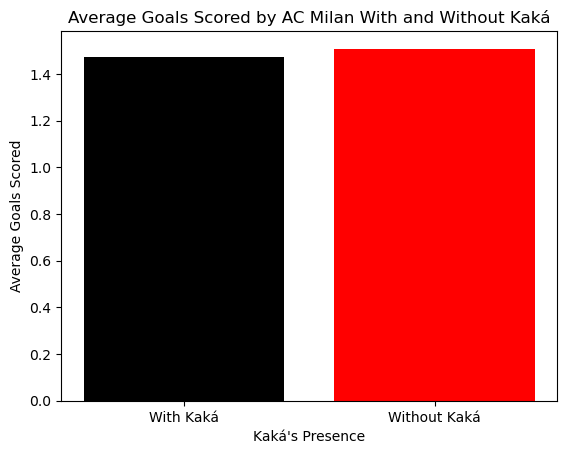

In [37]:
# Data for plotting
categories = ['With Kaká', 'Without Kaká']
avg_goals = [milan_with_kaka["home_team_goal"].mean(), milan_without_kaka["home_team_goal"].mean()]

# Plotting
plt.bar(categories, avg_goals, color=['black', 'red'])
plt.xlabel('Kaká\'s Presence')
plt.ylabel('Average Goals Scored')
plt.title('Average Goals Scored by AC Milan With and Without Kaká')
plt.show()

# Logistic Regression 

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Step 2: Prepare the data
X = milan_matches[['kaka_played']]  # Feature: Kaká's presence (binary: 1 if Kaká played, 0 if not)
y = milan_matches['home_team_goal'] > milan_matches['away_team_goal']  # Target: Win (1) or Loss (0)

# Step 3: Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Step 5: Make predictions on the test set
y_pred = model.predict(X_test)

# Step 6: Evaluate the model’s accuracy
accuracy = accuracy_score(y_test, y_pred)

# Step 7: Print the accuracy
print(f'Accuracy of the Logistic Regression model: {accuracy}')


Accuracy of the Logistic Regression model: 0.47540983606557374
